<a href="https://colab.research.google.com/github/whyeon92/ESAA_YB/blob/mini_project/miniproject3_MLR_Ridge_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
#파일 경로 지정 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/ESAAData/miniproject3_data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **데이터 불러오기**

In [81]:
import pandas as pd

train=pd.read_csv(path + "movies_train.csv")
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [82]:
test=pd.read_csv(path + 'movies_test.csv')
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [83]:
sub=pd.read_csv(path + "submission.csv")
sub.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


# **train, test 데이터 전처리**

In [84]:
# 결측치 처리
train['dir_prev_bfnum'].fillna(0, inplace=True)
test['dir_prev_bfnum'].fillna(0, inplace=True)

# release_year, release_month 데이터 생성
train['release_time']=pd.to_datetime(train['release_time']) # dt method 사용을 위해 날짜 형식으로 변환
test['release_time']=pd.to_datetime(test['release_time'])
train['release_year']=pd.to_numeric(train['release_time'].dt.year)
test['release_year']=pd.to_numeric(test['release_time'].dt.year)
train['release_month']=pd.to_numeric(train['release_time'].dt.month)
test['release_month']=pd.to_numeric(test['release_time'].dt.month)

# 불필요한 피처 제거
train=train.drop(['title','director','release_time'], axis=1)
test=test.drop(['title','director','release_time'], axis=1)

# train 데이터 'dir_prev_bfnum' 이상치 삭제
train = train.sort_values(by='dir_prev_bfnum', ascending=False).iloc[1:]

# test 데이터 'time' 이상치 삭제
test.sort_values(by='time', ascending=False)[0]=63

In [85]:
# 중복 distributor 처리
def distr_preprocessing(x) :
    if 'CGV' in x or '무비꼴라쥬' in x :
        return 'CGV'
    elif 'E&M' in x or 'CJ엔터테인먼트' in x or 'CJ 엔터테인먼트' in x:
        return 'CJ E&M'
    elif '롯데' in x :
        return '롯데엔터테인먼트'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x or 'KT' in x:
        return '싸이더스'
    elif '마운틴' in x:
        return '마운틴픽쳐스'
    elif '메가박스' in x or '씨너스' in x:
        return '메가박스플러스엠'
    elif '쇼박스' in x or '(주)쇼박스' in x :
        return '쇼박스'
    elif '조이앤시네마' in x or '조이앤컨텐츠그룹' in x or '(주) 케이알씨지' in x or '드림팩트' in x:
        return '조이앤'
    elif '타임스토리' in x :
        return '타임스토리'
    elif '프리비젼' in x :
        return '프리비젼'
    elif '리틀빅픽' in x :
        return '리틀빅픽쳐스'
    elif '콘텐츠판다' in x or 'NEW' in x:
        return 'NEW'
    elif 'SK' in x:
        return 'SK'
    elif '마인스' in x:
        return '마인스'
    elif '에이원' in x:
        return '에이원'
    elif 'THE 픽쳐스' in x or '더픽쳐스' in x:
        return '더픽쳐스'
    elif '시네마 달' in x or '(주)시네마달' in x:
        return '시네마달'
    elif '와이드 릴리즈' in x or '와이드릴리즈' in x:
        return '와이드릴리즈'
    else :
        return x

train['distributor']=train['distributor'].apply(distr_preprocessing)
test['distributor']=test['distributor'].apply(distr_preprocessing)

In [86]:
# 상위 14개 배급사를 제외한 배급사는 '기타'로 처리
dist_train=train.distributor.value_counts()[:14]

def distributor_etc(x):
  if x in dist_train:
    return x
  else:
    return('기타')

train['distributor']=train['distributor'].apply(distributor_etc).apply(lambda x : distributor_etc(x))

dist_test = dist_train.index.tolist()
test['distributor'] = test['distributor'].apply(lambda x : x if x in dist_test else '기타')

상위 14개 배급사 : 롯데엔터테인먼트 쇼박스 NEW 조이앤 CJ E&M CGV 인디스토리 영화사 진진 마운틴픽쳐스 골든타이드픽처스 시너지 시네마달 싸이더스 어뮤즈

In [87]:
# 관객수 log 변환 데이터 생성
import numpy as np

train_log=train.copy()
train_log['box_off_num']=np.log1p(train_log['box_off_num'])

In [88]:
# 원핫인코딩
train=pd.get_dummies(train, columns=['genre','distributor','screening_rat','release_year','release_month'], drop_first=True)
train_log=pd.get_dummies(train_log, columns=['genre','distributor','screening_rat','release_year','release_month'], drop_first=True)
test=pd.get_dummies(test, columns=['genre','distributor','screening_rat','release_year','release_month'], drop_first=True)

train=train.astype(int)
train_log=train_log.astype(int)
test=test.astype(int)

# **train/log 변환 train 데이터 X, y로 나누기**

In [89]:
y_train=train['box_off_num']
X_train=train.drop(['box_off_num'], axis=1, inplace=False)

In [90]:
y_log_train=train_log['box_off_num']
X_log_train=train_log.drop(['box_off_num'], axis=1, inplace=False)

In [91]:
X_train.columns

Index(['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor',
       'genre_공포', 'genre_느와르', 'genre_다큐멘터리', 'genre_드라마', 'genre_멜로/로맨스',
       'genre_뮤지컬', 'genre_미스터리', 'genre_서스펜스', 'genre_애니메이션', 'genre_액션',
       'genre_코미디', 'distributor_CGV', 'distributor_CJ E&M', 'distributor_NEW',
       'distributor_골든타이드픽처스', 'distributor_기타', 'distributor_롯데엔터테인먼트',
       'distributor_마운틴픽쳐스', 'distributor_쇼박스', 'distributor_시너지',
       'distributor_시네마달', 'distributor_싸이더스', 'distributor_어뮤즈',
       'distributor_인디스토리', 'distributor_조이앤', 'screening_rat_15세 관람가',
       'screening_rat_전체 관람가', 'screening_rat_청소년 관람불가', 'release_year_2011',
       'release_year_2012', 'release_year_2013', 'release_year_2014',
       'release_year_2015', 'release_month_2', 'release_month_3',
       'release_month_4', 'release_month_5', 'release_month_6',
       'release_month_7', 'release_month_8', 'release_month_9',
       'release_month_10', 'release_month_11', 'release_month_12'],
      

In [92]:
# 연속형 변수 선택
continuous_vars=['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']
# 원핫인코딩 변수 선택
one_hot_vars = ['genre_공포', 'genre_느와르', 'genre_다큐멘터리', 'genre_드라마', 'genre_멜로/로맨스',
       'genre_뮤지컬', 'genre_미스터리', 'genre_서스펜스', 'genre_애니메이션', 'genre_액션',
       'genre_코미디', 'distributor_CJ E&M', 'distributor_NEW',
       'distributor_골든타이드픽처스', 'distributor_기타', 'distributor_롯데엔터테인먼트',
       'distributor_마운틴픽쳐스', 'distributor_쇼박스', 'distributor_시너지',
       'distributor_시네마달', 'distributor_싸이더스', 'distributor_어뮤즈',
       'distributor_영화사 진진', 'distributor_인디스토리', 'distributor_조이앤',
       'screening_rat_15세 관람가', 'screening_rat_전체 관람가',
       'screening_rat_청소년 관람불가', 'release_year_2011', 'release_year_2012',
       'release_year_2013', 'release_year_2014', 'release_year_2015',
       'release_month_2', 'release_month_3', 'release_month_4',
       'release_month_5', 'release_month_6', 'release_month_7',
       'release_month_8', 'release_month_9', 'release_month_10',
       'release_month_11', 'release_month_12']

In [93]:
# standard scaling
X_standard_train=X_train.copy()
X_log_standard_train=X_log_train.copy()
standard_test=test.copy()

from sklearn.preprocessing import StandardScaler
standard_scaler=StandardScaler()
X_standard_train[continuous_vars]=standard_scaler.fit_transform(X_standard_train[continuous_vars])
X_log_standard_train[continuous_vars]=standard_scaler.transform(X_log_standard_train[continuous_vars])
standard_test[continuous_vars]=standard_scaler.transform(standard_test[continuous_vars])

In [94]:
# minmax scaling
X_minmax_train=X_train.copy()
minmax_test=test.copy()
X_log_minmax_train=X_log_train.copy()

from sklearn.preprocessing import MinMaxScaler
minmax_scaler=MinMaxScaler()
X_minmax_train[continuous_vars]=minmax_scaler.fit_transform(X_minmax_train[continuous_vars])
X_log_minmax_train[continuous_vars]=minmax_scaler.transform(X_log_minmax_train[continuous_vars])
minmax_test[continuous_vars]=minmax_scaler.transform(minmax_test[continuous_vars])

# MLR

선형회귀는 스케일링의 영향을 크게 받지 않기에 결과가 거의 같은 값

In [95]:
from sklearn.linear_model import LinearRegression, Ridge

In [96]:
import matplotlib.pyplot as plt

In [97]:
#X, X
MLR = LinearRegression()
MLR.fit(X_train, y_train)
pred = MLR.predict(test)

In [98]:
for i in range(len(pred)):
  if pred[i] < 0:
     pred[i] = 0

In [99]:
sub['box_off_num'] = pred
sub.to_csv(path + 'submission_MLR_X.csv', index=False)

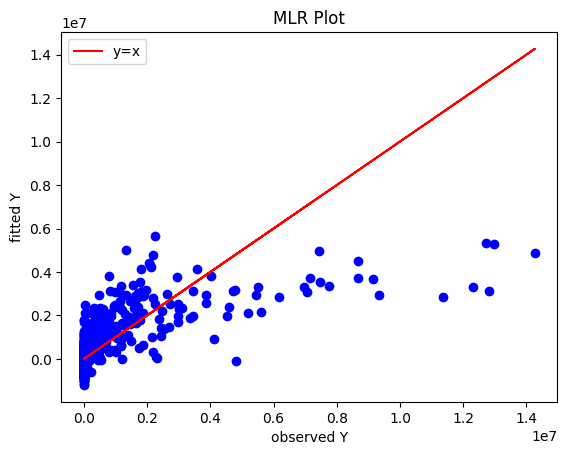

In [100]:
plt.scatter(y_train, MLR.predict(X_train), color = "b")
plt.plot(y_train, y_train, color = "r", label = "y=x")
plt.xlabel("observed Y")
plt.ylabel("fitted Y")
plt.title("MLR Plot")
plt.legend()
plt.show()

In [101]:
#minmax, X
MLR = LinearRegression()
MLR.fit(X_minmax_train, y_train)
pred = MLR.predict(minmax_test)

In [102]:
for i in range(len(pred)):
  if pred[i] < 0:
     pred[i] = 0

In [103]:
sub['box_off_num'] = pred
sub.to_csv(path + 'submission_MLR_MM.csv', index=False)

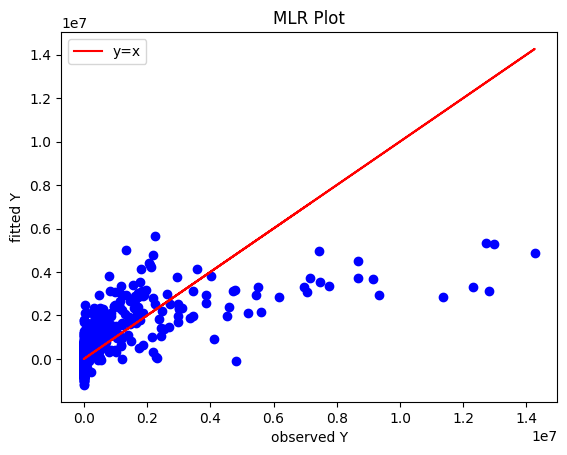

In [104]:
plt.scatter(y_train, MLR.predict(X_minmax_train), color = "b")
plt.plot(y_train, y_train, color = "r", label = "y=x")
plt.xlabel("observed Y")
plt.ylabel("fitted Y")
plt.title("MLR Plot")
plt.legend()
plt.show()

In [105]:
#Standard, X
MLR = LinearRegression()
MLR.fit(X_standard_train, y_train)
pred = MLR.predict(standard_test)

In [106]:
for i in range(len(pred)):
  if pred[i] < 0:
     pred[i] = 0

In [107]:
sub['box_off_num'] = pred
sub.to_csv(path + 'submission_MLR_SS.csv', index=False)

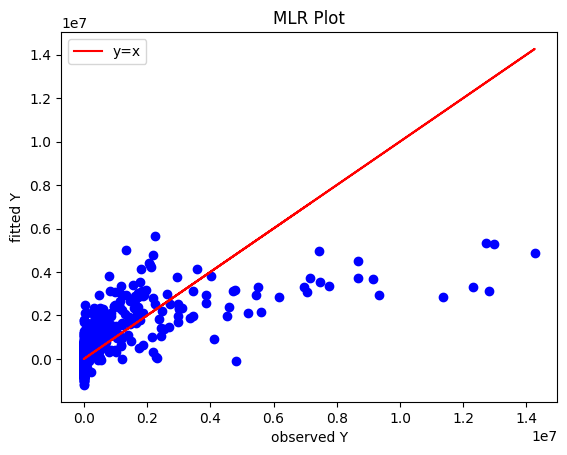

In [108]:
plt.scatter(y_train, MLR.predict(X_standard_train), color = "b")
plt.plot(y_train, y_train, color = "r", label = "y=x")
plt.xlabel("observed Y")
plt.ylabel("fitted Y")
plt.title("MLR Plot")
plt.legend()
plt.show()

# Ridge

In [109]:
#X, X
ridge = Ridge()
ridge.fit(X_train, y_train)
pred = ridge.predict(test)

In [110]:
for i in range(len(pred)):
  if pred[i] < 0:
     pred[i] = 0

In [111]:
sub['box_off_num'] = pred
sub.to_csv(path + 'submission_Ridge_X.csv', index=False)

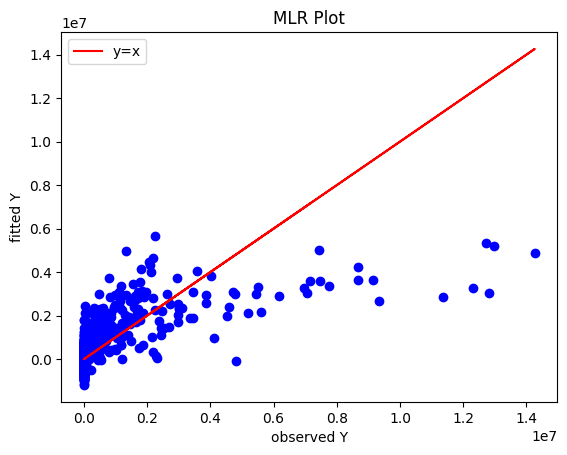

In [112]:
plt.scatter(y_train, ridge.predict(X_train), color = "b")
plt.plot(y_train, y_train, color = "r", label = "y=x")
plt.xlabel("observed Y")
plt.ylabel("fitted Y")
plt.title("MLR Plot")
plt.legend()
plt.show()

In [113]:
#minmax, X
ridge = Ridge()
ridge.fit(X_minmax_train, y_train)
pred = ridge.predict(minmax_test)

In [114]:
for i in range(len(pred)):
  if pred[i] < 0:
     pred[i] = 0

In [115]:
sub['box_off_num'] = pred
sub.to_csv(path + 'submission_Ridge_MM.csv', index=False)

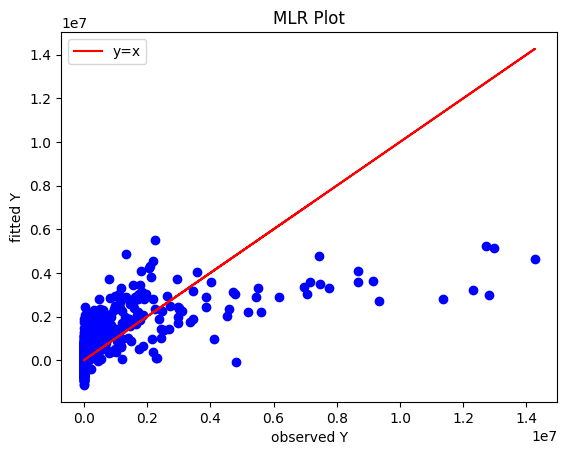

In [116]:
plt.scatter(y_train, ridge.predict(X_minmax_train), color = "b")
plt.plot(y_train, y_train, color = "r", label = "y=x")
plt.xlabel("observed Y")
plt.ylabel("fitted Y")
plt.title("MLR Plot")
plt.legend()
plt.show()

In [117]:
#Standard, X
ridge = Ridge()
ridge.fit(X_standard_train, y_train)
pred = ridge.predict(standard_test)

In [118]:
for i in range(len(pred)):
  if pred[i] < 0:
     pred[i] = 0

In [119]:
sub['box_off_num'] = pred
sub.to_csv(path + 'submission_Ridge_SS.csv', index=False)

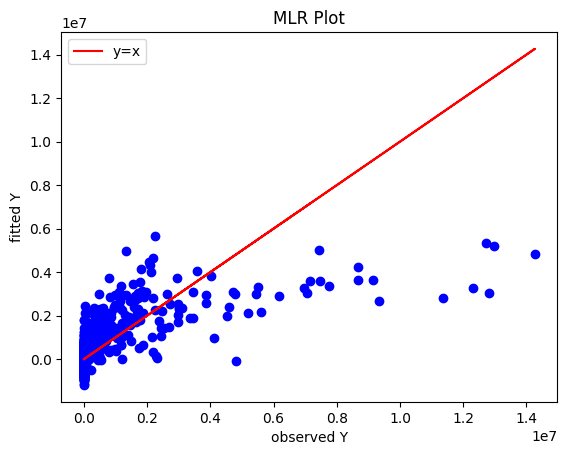

In [120]:
plt.scatter(y_train, ridge.predict(X_standard_train), color = "b")
plt.plot(y_train, y_train, color = "r", label = "y=x")
plt.xlabel("observed Y")
plt.ylabel("fitted Y")
plt.title("MLR Plot")
plt.legend()
plt.show()

## Ridge GridSearch

In [121]:
from sklearn.model_selection import GridSearchCV

In [122]:
ridge_alpha = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5,
                         1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50,
                         60, 70, 80 ,90, 100, 110, 125, 150, 200]}

In [123]:
#X, X
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid = ridge_alpha, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1, refit=True)
grid_ridge.fit(X_train, y_train)
pred = grid_ridge.predict(test)

print('최적 하이퍼 파라미터:\n', grid_ridge.best_params_)
print('최고 예측 RMSE: {0:.4f}'.format(-1* grid_ridge.best_score_))

최적 하이퍼 파라미터:
 {'alpha': 110}
최고 예측 RMSE: 1464838.3711


In [124]:
for i in range(len(pred)):
  if pred[i] < 0:
     pred[i] = 0

In [125]:
sub['box_off_num'] = pred
sub.to_csv(path + 'submission_Grid_X.csv', index=False)

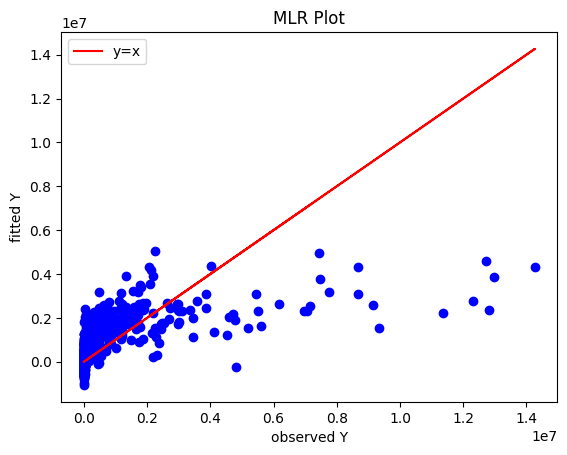

In [126]:
plt.scatter(y_train, grid_ridge.predict(X_train), color = "b")
plt.plot(y_train, y_train, color = "r", label = "y=x")
plt.xlabel("observed Y")
plt.ylabel("fitted Y")
plt.title("MLR Plot")
plt.legend()
plt.show()

In [127]:
#minmax, X
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid = ridge_alpha, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1, refit=True)
grid_ridge.fit(X_minmax_train, y_train)
pred = grid_ridge.predict(minmax_test)

print('최적 하이퍼 파라미터:\n', grid_ridge.best_params_)
print('최고 예측 RMSE: {0:.4f}'.format(-1* grid_ridge.best_score_))

최적 하이퍼 파라미터:
 {'alpha': 3}
최고 예측 RMSE: 1387624.0501


In [128]:
for i in range(len(pred)):
  if pred[i] < 0:
     pred[i] = 0

In [129]:
sub['box_off_num'] = pred
sub.to_csv(path + 'submission_Grid_MM.csv', index=False)

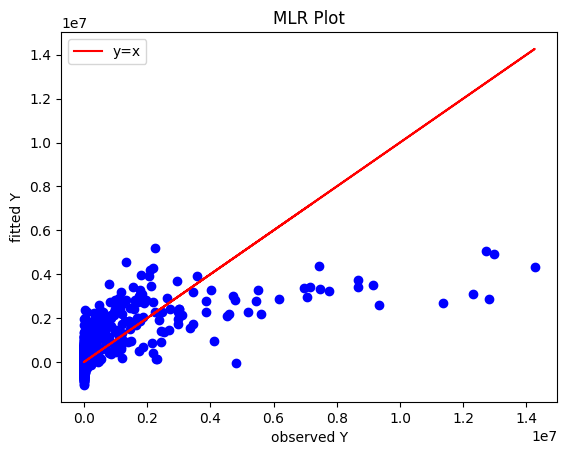

In [130]:
plt.scatter(y_train, grid_ridge.predict(X_minmax_train), color = "b")
plt.plot(y_train, y_train, color = "r", label = "y=x")
plt.xlabel("observed Y")
plt.ylabel("fitted Y")
plt.title("MLR Plot")
plt.legend()
plt.show()

In [131]:
#Standard, X
ridge = Ridge()
grid_ridge = GridSearchCV(ridge, param_grid = ridge_alpha, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1, refit=True)
grid_ridge.fit(X_standard_train, y_train)
pred = grid_ridge.predict(standard_test)

print('최적 하이퍼 파라미터:\n', grid_ridge.best_params_)
print('최고 예측 RMSE: {0:.4f}'.format(-1* grid_ridge.best_score_))

최적 하이퍼 파라미터:
 {'alpha': 30}
최고 예측 RMSE: 1382651.7379


In [132]:
for i in range(len(pred)):
  if pred[i] < 0:
     pred[i] = 0

In [133]:
sub['box_off_num'] = pred
sub.to_csv(path + 'submission_Grid_SS.csv', index=False)

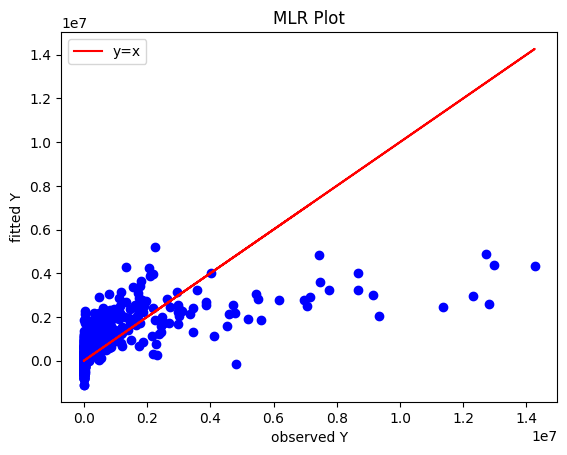

In [134]:
plt.scatter(y_train, grid_ridge.predict(X_standard_train), color = "b")
plt.plot(y_train, y_train, color = "r", label = "y=x")
plt.xlabel("observed Y")
plt.ylabel("fitted Y")
plt.title("MLR Plot")
plt.legend()
plt.show()